#**Covid Correct Handwashing Predicition**


This notebook aims to create and test a deep learning model for predicting proper handwashing procedures in the context of COVID-19, using an image dataset divided into 8 classes of the correct handwashing procedure. The purpose is to preprocess the data, create an effective model, and assess its performance to ensure accurate predictions.

# **1. Importing Required Libraries**

In [11]:
# Install essential libraries
!pip install cleanlab tensorflow opencv-python xgboost

# Import required libraries
import xgboost as xgb
import os
import shutil
import numpy as np
from google.colab import drive
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from cleanlab.classification import CleanLearning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import json
import hashlib


# **2. Loading The Data**

### **2.1. Mounting Google Drive**

In [12]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset path in Google Drive
dataset_path = '/content/drive/MyDrive/CHS2406_Coursework2_Data_Repository'

# Verify if the repository exists
if os.path.exists(dataset_path):
    print(f"Dataset path found: {dataset_path}")
else:
    print(f"Error: Dataset path not found at {dataset_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path found: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository


## **2.2. Sampling and Saving Images**

In [13]:
# Sampling and saving sampled images
import random
import os
import json

# Define paths
dataset_path = '/content/drive/MyDrive/CHS2406_Coursework2_Data_Repository'  # Original dataset path
sampled_file = '/content/drive/MyDrive/sampled_images.json'  # File to save sampled images
sample_size = 650  # Set the sample size (number of images per class)

# Set random seed for reproducibility
random.seed(42)

# Sampling function
def sample_images(dataset_path, sample_size):
    sampled_images = {}
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            # Save full paths of sampled images
            sampled_images[class_name] = [
                os.path.join(class_dir, img) for img in random.sample(images, min(sample_size, len(images)))
            ]
    return sampled_images

# Perform sampling and save to a JSON file
if not os.path.exists(sampled_file):  # Only sample if not already saved
    sampled_images = sample_images(dataset_path, sample_size)
    with open(sampled_file, 'w') as f:
        json.dump(sampled_images, f)
    print(f"Sampled images saved to: {sampled_file}")
else:
    with open(sampled_file, 'r') as f:
        sampled_images = json.load(f)
    print(f"Sampled images loaded from: {sampled_file}")

# Verify the sampled images
for class_name, image_paths in sampled_images.items():
    print(f"Class {class_name}: {len(image_paths)} sampled images")
    for img_path in image_paths[:5]:  # Print the first 5 image paths for verification
        print(f"   - {img_path}")


Sampled images loaded from: /content/drive/MyDrive/sampled_images.json
Class Stage4: 650 sampled images
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_04_U2174467_6.jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_U2160540_10.jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_U2066752 (7).jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_2259343(8).jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_U2261828 (2).jpeg
Class Stage6: 650 sampled images
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage6/Stage_6_u2263601.jpg(10).jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage6/Stage_60_U2180946.jpeg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage6/Stage_6_u2271070_(4).jpg
   - /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage6/Stage_6_u2259068(6).jpg
 

In [14]:
import json

# Verify the contents of the sampled file
sampled_file = '/content/drive/MyDrive/sampled_images.json'

if os.path.exists(sampled_file):
    with open(sampled_file, 'r') as f:
        sampled_images = json.load(f)
    print(f"Sampled images successfully loaded from: {sampled_file}")
    for class_name, images in sampled_images.items():
        print(f"Class {class_name}: {len(images)} sampled images")
else:
    print(f"Sampled file not found: {sampled_file}")


Sampled images successfully loaded from: /content/drive/MyDrive/sampled_images.json
Class Stage4: 650 sampled images
Class Stage6: 650 sampled images
Class Stage7: 650 sampled images
Class Stage8: 650 sampled images
Class Stage3: 650 sampled images
Class Stage2: 650 sampled images
Class Stage1: 650 sampled images
Class Stage5: 650 sampled images


# **3. Data Labelling Errors**

In [15]:
import os
import shutil
import hashlib
import json
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array

# Define paths
sampled_file = '/content/drive/MyDrive/sampled_images.json'
cleaned_dir = '/content/drive/MyDrive/cleaned_sampled_dataset'
error_summary_file = '/content/drive/MyDrive/error_summary.json'

# Verify the existence of the sampled file
if not os.path.exists(sampled_file):
    raise FileNotFoundError(f"Sampled file not found: {sampled_file}. Please ensure sampling is completed in Step 2.2.")

# Check if cleaned_dir exists and skip processing if it does
if os.path.exists(cleaned_dir) and len(os.listdir(cleaned_dir)) > 0:
    print(f"Cleaned dataset already exists at: {cleaned_dir}. Skipping processing...")

    # If error summary exists, load and output it
    if os.path.exists(error_summary_file):
        with open(error_summary_file, 'r') as f:
            error_summary = json.load(f)

        structural_errors_by_stage = error_summary["structural_errors"]
        label_mismatches_by_stage = error_summary["label_mismatches"]
        class_counts = error_summary["class_counts"]

        # Output results from the summary
        print("\nStructural Errors Summary:")
        for stage, errors in structural_errors_by_stage.items():
            print(f"Stage {stage}: {len(errors)} structural errors")
            for error in errors[:5]:
                print(f"   - File: {error['file']} | Error: {error['error']}")
            if len(errors) > 5:
                print(f"   ... and {len(errors) - 5} more errors.\n")

        print("\nLabel Errors Summary:")
        for stage, mismatches in label_mismatches_by_stage.items():
            print(f"Stage {stage}: {len(mismatches)} label mismatches")
            for mismatch in mismatches[:5]:
                print(f"   - File: {mismatch['file']} | Predicted: {mismatch['predicted']} | Actual: {mismatch['actual']}")
            if len(mismatches) > 5:
                print(f"   ... and {len(mismatches) - 5} more mismatches.\n")
else:
    print(f"Cleaned dataset not found at: {cleaned_dir}. Processing dataset...")

    # Load sampled images from JSON
    with open(sampled_file, 'r') as f:
        sampled_images = json.load(f)

    # Initialize variables for error handling
    structural_errors_by_stage = {class_name: [] for class_name in sampled_images.keys()}
    label_mismatches_by_stage = {class_name: [] for class_name in sampled_images.keys()}
    class_counts = {class_name: 0 for class_name in sampled_images.keys()}
    image_hashes = set()

    # Function to compute MD5 hash for duplicate detection
    def compute_md5(file_path):
        hash_md5 = hashlib.md5()
        with open(file_path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()

    # Function to predict class using the pre-trained Xception model
    pretrained_model = Xception(weights='imagenet', include_top=True)

    def predict_label(img_path):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array[np.newaxis, ...])
        predictions = pretrained_model.predict(img_array, verbose=0)
        predicted_class = decode_predictions(predictions, top=1)[0][0][1]
        return predicted_class

    # Process dataset for structural and labeling issues
    for class_name, image_paths in sampled_images.items():
        for img_path in image_paths:
            try:
                # Check if the file exists
                if not os.path.exists(img_path):
                    structural_errors_by_stage[class_name].append(
                        {"file": img_path, "error": "Missing file"}
                    )
                    continue

                # Check if the file is empty
                if os.path.getsize(img_path) == 0:
                    structural_errors_by_stage[class_name].append(
                        {"file": img_path, "error": "Empty file"}
                    )
                    continue

                # Check for duplicate images using MD5 hashes
                img_hash = compute_md5(img_path)
                if img_hash in image_hashes:
                    structural_errors_by_stage[class_name].append(
                        {"file": img_path, "error": "Duplicate image detected"}
                    )
                    continue
                image_hashes.add(img_hash)

                # Attempt to load the image for corruption check
                tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))

                # Perform label validation
                predicted_label = predict_label(img_path)
                if predicted_label.lower() != class_name.lower():
                    label_mismatches_by_stage[class_name].append(
                        {"file": img_path, "predicted": predicted_label, "actual": class_name}
                    )
                    continue

                # Count the valid image for the class
                class_counts[class_name] += 1

            except Exception as e:
                structural_errors_by_stage[class_name].append(
                    {"file": img_path, "error": str(e)}
                )

    # Save the cleaned dataset
    if not os.path.exists(cleaned_dir):
        os.makedirs(cleaned_dir)
    for class_name, image_paths in sampled_images.items():
        cleaned_class_dir = os.path.join(cleaned_dir, class_name)
        os.makedirs(cleaned_class_dir, exist_ok=True)
        for img_path in image_paths:
            if os.path.exists(img_path) and img_path not in [e["file"] for e in structural_errors_by_stage[class_name]]:
                shutil.copy(img_path, os.path.join(cleaned_class_dir, os.path.basename(img_path)))

    # Save error summary to JSON
    error_summary = {
        "structural_errors": structural_errors_by_stage,
        "label_mismatches": label_mismatches_by_stage,
        "class_counts": class_counts
    }
    with open(error_summary_file, 'w') as f:
        json.dump(error_summary, f)

    print(f"Cleaned dataset saved to: {cleaned_dir}")
    print(f"Error summary saved to: {error_summary_file}")

    # Output final results
    print("\nStructural Errors Summary:")
    for stage, errors in structural_errors_by_stage.items():
        print(f"Stage {stage}: {len(errors)} structural errors")
        for error in errors[:5]:
            print(f"   - File: {error['file']} | Error: {error['error']}")
        if len(errors) > 5:
            print(f"   ... and {len(errors) - 5} more errors.\n")

    print("\nLabel Errors Summary:")
    for stage, mismatches in label_mismatches_by_stage.items():
        print(f"Stage {stage}: {len(mismatches)} label mismatches")
        for mismatch in mismatches[:5]:
            print(f"   - File: {mismatch['file']} | Predicted: {mismatch['predicted']} | Actual: {mismatch['actual']}")
        if len(mismatches) > 5:
            print(f"   ... and {len(mismatches) - 5} more mismatches.\n")


Cleaned dataset already exists at: /content/drive/MyDrive/cleaned_sampled_dataset. Skipping processing...

Structural Errors Summary:
Stage Stage4: 16 structural errors
   - File: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/8__Stage_4_u2180706.jpg | Error: Duplicate image detected
   - File: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_U2265620(3).jpeg | Error: cannot identify image file <_io.BytesIO object at 0x7ac0b1cd9bc0>
   - File: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage_4_2453664 - (7).jpg | Error: Duplicate image detected
   - File: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage 4 angle 7.jpg | Error: Duplicate image detected
   - File: /content/drive/MyDrive/CHS2406_Coursework2_Data_Repository/Stage4/Stage 4 angle 7 U2266514.jpg | Error: Duplicate image detected
   ... and 11 more errors.

Stage Stage6: 14 structural errors
   - File: /content/drive/MyDrive/CHS2406_Course

In [16]:
import os

cleaned_dir = '/content/drive/MyDrive/cleaned_sampled_dataset'

# Count total files in cleaned dataset
print("Inspecting the cleaned dataset directory...")

total_files = 0
class_file_counts = {}

for class_name in os.listdir(cleaned_dir):
    class_dir = os.path.join(cleaned_dir, class_name)
    if os.path.isdir(class_dir):
        num_files = len(os.listdir(class_dir))
        total_files += num_files
        class_file_counts[class_name] = num_files

print("Files per class:")
for class_name, count in class_file_counts.items():
    print(f" - {class_name}: {count} images")


Inspecting the cleaned dataset directory...
Files per class:
 - Stage4: 634 images
 - Stage6: 636 images
 - Stage7: 638 images
 - Stage8: 636 images
 - Stage3: 627 images
 - Stage2: 637 images
 - Stage1: 626 images
 - Stage5: 631 images


# **4. Data Pre Processing And Splitting the Data**

In [41]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
cleaned_dir = '/content/drive/MyDrive/cleaned_sampled_dataset'
split_dir = '/content/drive/MyDrive/splits'
train_dir = os.path.join(split_dir, "train")
val_dir = os.path.join(split_dir, "val")
test_dir = os.path.join(split_dir, "test")

# Ensure splits directory exists
os.makedirs(split_dir, exist_ok=True)

# Check if directories exist and clear them
for directory in [train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Clear existing directory
    os.makedirs(directory)  # Recreate it

# Split Data
X_train_file = '/content/drive/MyDrive/X_train.npy'
X_val_file = '/content/drive/MyDrive/X_val.npy'
X_test_file = '/content/drive/MyDrive/X_test.npy'
y_train_file = '/content/drive/MyDrive/y_train.npy'
y_val_file = '/content/drive/MyDrive/y_val.npy'
y_test_file = '/content/drive/MyDrive/y_test.npy'

if all(os.path.exists(f) for f in [X_train_file, X_val_file, X_test_file, y_train_file, y_val_file, y_test_file]):
    print("Saved splits found. Loading data...")
    X_train = np.load(X_train_file)
    X_val = np.load(X_val_file)
    X_test = np.load(X_test_file)
    y_train = np.load(y_train_file)
    y_val = np.load(y_val_file)
    y_test = np.load(y_test_file)
else:
    print("No saved splits found. Running preprocessing and splitting...")

    # Load all images and labels
    images, labels = [], []
    class_names = sorted(os.listdir(cleaned_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(cleaned_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                images.append(os.path.join(class_dir, img_file))
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)

    # Split into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

    # Copy files to train, val, test directories
    def save_split(X, y, split_dir):
        for img_path, label in zip(X, y):
            label_dir = os.path.join(split_dir, str(label))
            os.makedirs(label_dir, exist_ok=True)
            shutil.copy(img_path, os.path.join(label_dir, os.path.basename(img_path)))

    save_split(X_train, y_train, train_dir)
    save_split(X_val, y_val, val_dir)
    save_split(X_test, y_test, test_dir)

    # Save splits as numpy arrays
    np.save(X_train_file, X_train)
    np.save(X_val_file, X_val)
    np.save(X_test_file, X_test)
    np.save(y_train_file, y_train)
    np.save(y_val_file, y_val)
    np.save(y_test_file, y_test)

    print("Splits saved successfully.")

# Verify splits
for split_name, directory in zip(["Training", "Validation", "Testing"], [train_dir, val_dir, test_dir]):
    num_files = sum([len(files) for _, _, files in os.walk(directory)])
    print(f"{split_name} images: {num_files}")


No saved splits found. Running preprocessing and splitting...
Splits saved successfully.
Training images: 3241
Validation images: 811
Testing images: 1013


In [42]:
import os

def count_files_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

train_dir = '/content/drive/MyDrive/splits/train'
val_dir = '/content/drive/MyDrive/splits/val'
test_dir = '/content/drive/MyDrive/splits/test'

print(f"Training images: {count_files_in_dir(train_dir)}")
print(f"Validation images: {count_files_in_dir(val_dir)}")
print(f"Testing images: {count_files_in_dir(test_dir)}")


Training images: 3241
Validation images: 811
Testing images: 1013


# **5. Model Implementation**

In [35]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load the Xception model with pre-trained weights, excluding the top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze most of the base model layers initially
for layer in base_model.layers[:-25]:  # Keep the last 25 layers trainable for fine-tuning
    layer.trainable = False

# Build the new model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Global average pooling layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Fully connected layer with L2 regularization
    Dropout(0.4),  # Dropout layer for regularization
    Dense(8, activation='softmax')  # Output layer for 8 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

# Save the model architecture to a JSON file
model_architecture_path = '/content/drive/MyDrive/xception_model_architecture.json'
model_json = model.to_json()
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

print(f"Model architecture saved to: {model_architecture_path}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,784 (80.58 MB)

 Trainable params: 8,665,664 (33.06 MB)

 Non-trainable params: 12,459,120 (47.53 MB)

Model architecture saved to: /content/drive/MyDrive/xception_model_architecture.json


In [37]:
import json
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Paths to save model weights and training history
model_weights_path = '/content/drive/MyDrive/xception_fine_tuned_weights.weights.h5'
training_history_path = '/content/drive/MyDrive/training_history.json'

# Check if a saved training history exists
if os.path.exists(training_history_path):
    print("Saved training history found. Skipping training...")

    # Load training history
    with open(training_history_path, 'r') as history_file:
        history = json.load(history_file)
        print(f"Training history loaded from: {training_history_path}")

        # Print epoch-wise training history in a readable format
        print("\nDetailed Training History:")
        print(f"{'Epoch':<10}{'Accuracy':<15}{'Loss':<15}{'Val_Accuracy':<15}{'Val_Loss':<15}")
        print("-" * 65)
        for epoch, (acc, loss, val_acc, val_loss) in enumerate(zip(history['accuracy'], history['loss'], history['val_accuracy'], history['val_loss']), start=1):
            print(f"{epoch:<10}{acc:<15.4f}{loss:<15.4f}{val_acc:<15.4f}{val_loss:<15.4f}")

else:
    print("No saved training history found. Starting training...")

    # Callback to save the best weights based on validation loss
    model_checkpoint = ModelCheckpoint(
        filepath=model_weights_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # Train the model using the saved splits for training and validation
    history = model.fit(
        train_flow,
        validation_data=val_flow,
        epochs=35,  # Set number of epochs
        callbacks=[model_checkpoint]
    )

    # Save training history
    with open(training_history_path, 'w') as history_file:
        json.dump(history.history, history_file)

    print(f"Training history saved to: {training_history_path}")

    # Print epoch-wise training history in a readable format
    print("\nDetailed Training History:")
    print(f"{'Epoch':<10}{'Accuracy':<15}{'Loss':<15}{'Val_Accuracy':<15}{'Val_Loss':<15}")
    print("-" * 65)
    for epoch, (acc, loss, val_acc, val_loss) in enumerate(zip(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']), start=1):
        print(f"{epoch:<10}{acc:<15.4f}{loss:<15.4f}{val_acc:<15.4f}{val_loss:<15.4f}")


No saved training history found. Starting training...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/splits/train/0/Stage_1_6u2289893.jpg'

# **6. Evaluating The Model**

Loading model weights from: /content/drive/MyDrive/xception_fine_tuned_weights.weights.h5
Found 1006 images belonging to 8 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.7015 - loss: 1.2392
Test Accuracy: 66.40%
Test Loss: 1.3208
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       125
           1       0.56      0.57      0.56       127
           2       0.60      0.58      0.59       125
           3       0.61      0.53      0.57       126
           4       0.67      0.59      0.63       123
           5       0.59      0.61      0.60       126
           6       0.64      0.80      0.71       127
           7       0.80      0.72      0.76       127

    accuracy                           0.66      1006
   macro avg       0.66      0.66      0.66      1006
weighted avg       0.66      0.66      0.66      1006



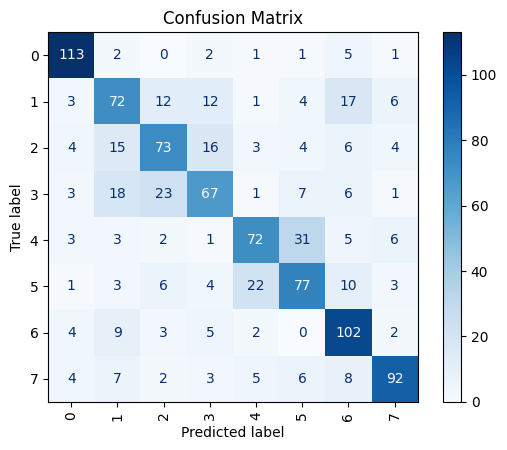

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Paths
model_weights_path = '/content/drive/MyDrive/xception_fine_tuned_weights.weights.h5'
test_dir = '/content/drive/MyDrive/splits/test'

# Check if model weights exist
if os.path.exists(model_weights_path):
    print(f"Loading model weights from: {model_weights_path}")
    # Load the model weights
    model.load_weights(model_weights_path)

    # Prepare test data generator
    test_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
    test_flow = test_data_gen.flow_from_directory(
        directory=test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_flow)
    print(f"Test Accuracy: {test_accuracy:.2%}")
    print(f"Test Loss: {test_loss:.4f}")

    # Predictions
    y_pred = np.argmax(model.predict(test_flow), axis=1)
    y_true = test_flow.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_flow.class_indices.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_flow.class_indices.keys())
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

else:
    print(f"Model weights not found at: {model_weights_path}. Please ensure the model is trained and weights are saved.")


###**6.1 - Training Curves**

Plotting training history...


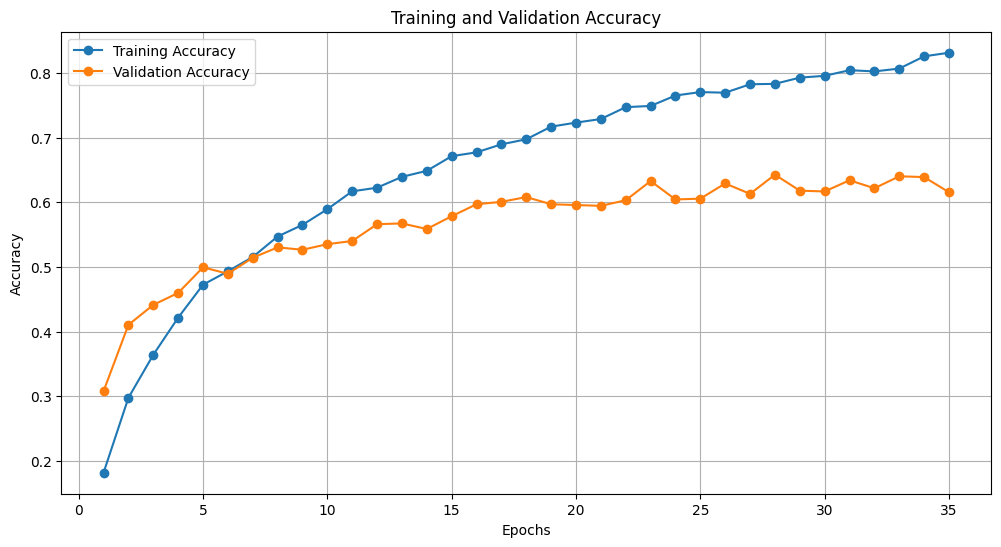

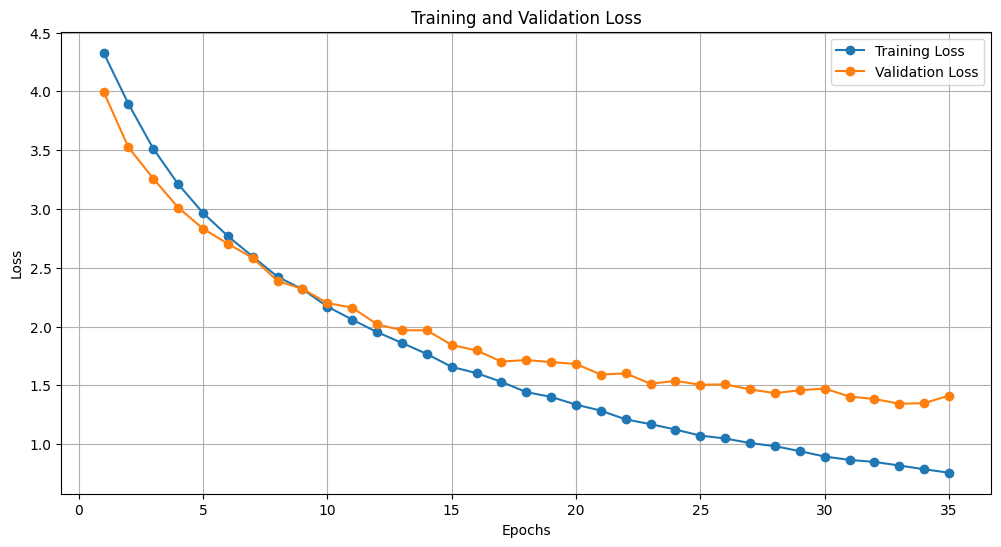

In [ ]:
# Training history visualization
print("Plotting training history...")

# Extract metrics
epochs = range(1, len(history['accuracy']) + 1)
train_acc = history['accuracy']
train_loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


###**6.2 - Unseen Data**